## Customer Segmentation
**Def:**
Customer segmentation is the process of dividing a client base into distinct groups or segments.

**Criteria for Segmentation:**
Segments are based on common features and behaviors among clients.

**Purpose**
Understanding each segment’s needs and preferences enables organizations to (i) Create targeted marketing efforts, and (ii) Enhance the effectiveness of marketing campaigns.

**Benefits**
Leads to greater client retention and increases overall revenue for the organization.

**Appraoches**
Two fundamental techniques can be applied: 
* RFM (Recency, Frequency, Monetary) analysis
* Clustering.




**Dataset Sources**
<a href="https://archive.ics.uci.edu/static/public/352/online+retail.zip">Public Archive</a>

**RFM analysis:**
* Recency (R): How recently did a particular customer make a purchase?
* Frequency (F): How often do they make purchases?
* Monetary Value (M): How much money do they spend?

In [1]:
# Import Necessary Libraries and Modules
import pandas as pd                     # for data exploration
import matplotlib.pyplot as plt         # for data visualization
from sklearn.cluster import KMeans      # for cluster clustering


In [2]:
# Load the dataset from UCI repository
data = pd.read_excel("online_retail.xlsx")

In [3]:
data.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# describe() method on the dataframe to understand the numerical features
data.describe()


,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


The “CustomerID” column is currently a floating point value. When we clean the data.

The “Quantity” and “UnitPrice” columns contain negative values (noise values).

In [5]:
# ook at the columns and their data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
# the count of missing values in each column:
missing_values = data.isnull().sum()
print(missing_values)

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


For our analysis, we don’t need the product description contained in the “Description” column. However, we need the “CustomerID” for the next steps in our analysis. So let’s drop the records with missing “CustomerID”:

In [7]:
# Drop rows with missing CustomerID
data.dropna(subset=['Customer ID'], inplace=True)

In [8]:
# Drop the records with negative values for  “Quantity” and “UnitPrice”.
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

# reverify the negative values
missing_values = data.isnull().sum()
print(missing_values)

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [18]:
# Convert the “Customer ID” to an integer, becasue there is no need of decimal point in id
data['Customer ID'] = data['Customer ID'].astype(int)

# Verify the data type conversion
print(data.dtypes)

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             int32
Country                object
dtype: object


**Compute Recency, Frequency, and Monetary Value**

To calculate the Recency, Frequency, and MonetaryValue, we calculate the following—grouped by CustomerID:

* For recency, we’ll calculate the difference between the most recent purchase date and a reference date (snapshot_date). This gives the number of days since the customer's last purchase. So smaller values indicate that a customer has made a purchase more recently. But when we talk about recency scores, we’d want customers who bought recently to have a higher recency score, yes? We’ll handle this in the next step.
* Because frequency measures how often a customer makes purchases, we’ll calculate it as the total number of unique invoices or transactions made by each customer.
* Monetary value quantifies how much money a customer spends. So we’ll find the average of the total monetary value across transactions.

* Defining a reference date snapshot_date that’s a day later than the most recent date in the “InvoiceDate” column

In [9]:
snapshot_date = max(data['InvoiceDate']) + pd.DateOffset(days=1)

In [10]:
print(max(data['InvoiceDate']))
snapshot_date

2010-12-09 20:01:00


Timestamp('2010-12-10 20:01:00')

In [11]:
# create a “Total” column that contains Quantity*UnitPrice 
# for all the records:
data['Total'] = data['Quantity'] * data['Price']

In [13]:
rfm = data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'Total': 'sum'
})

In [14]:
rfm

,InvoiceDate,Invoice,Total
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93
...,...,...,...
18283.0,18,6,641.77
18284.0,67,1,461.68
18285.0,296,1,427.00


In [15]:
# Let’s rename the columns for readability:
rfm.rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Total': 'MonetaryValue'}, inplace=True)
rfm.head()


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


In order to map the “Recency”, “Frequency”, and “MonetaryValue” columns to take on values in a scale of 1-5; one of {1,2,3,4,5}.

Assign the values to five different bins, and map each bin to a value based on the quantile values of the “Recency”, “Frequency”, and “MonetaryValue” columns.

In [16]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,2048.238236
std,96.860633,8.170213,8914.481280
min,1.000000,1.000000,2.950000
25%,18.000000,1.000000,307.987500
50%,53.000000,2.000000,706.020000
75%,136.000000,5.000000,1723.142500
max,374.000000,205.000000,349164.350000


In [17]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

In [18]:
recency_bins

[0, 20, 50, 150, 250, 374]

In [19]:
# Calculate Recency score based on custom bins 
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

Note that the R_Score, based on the bins, is 1 for current transactions and 5 for all purchases made more than 250 days prior. However, we would like the most recent purchases to have a R_Score of 5, whereas purchases made more than 250 days ago should have a R_Score of 1.


In [20]:
# To achieve the desired mapping, we do: 5 - rfm['R_Score'].astype(int) + 1.
# Few rows of the R_Score, F_Score, and M_Score columns:
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

             R_Score  F_Score  M_Score
Customer ID                           
12346.0            2        4        2
12347.0            5        1        3
12348.0            3        1        1
12349.0            4        2        4
12351.0            5        1        2
12352.0            5        1        2
12353.0            4        1        2
12355.0            2        1        2
12356.0            5        2        4
12357.0            4        1        5


## Clustering

We will employ K-Means clustering, which is scale-sensitive. Because the R, F, and M values are all on the same scale, we can cluster the features without scaling them further. 

In [21]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

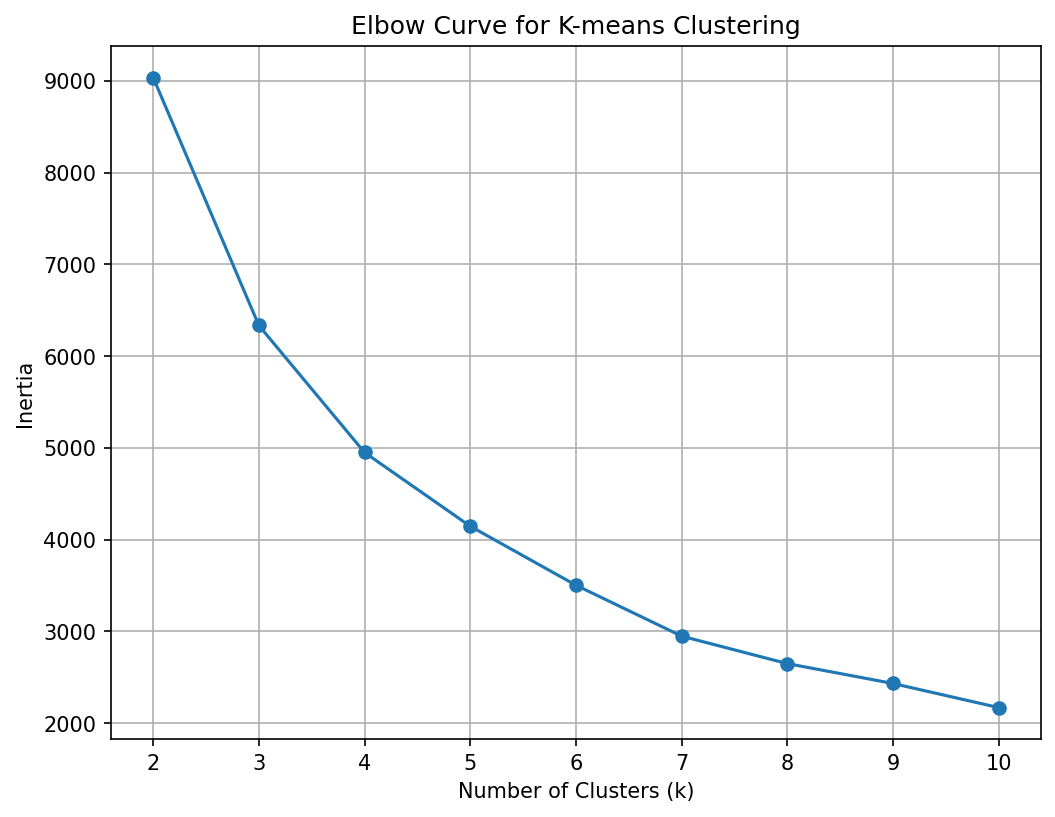

In [22]:
# find the optimal number of clusters for k  in k-means
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

We can see that the curve elbows out in four bunches. So, let's divide the customer base into four categories. or we can also try with 5.

Let's k=4

In [23]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

Interpret Clusters to Identify Customer Segments. Now that we have the clusters, let's try to characterize them using the RFM ratings.

In [24]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [25]:
# The average R, F, and M scores for each cluster should already give you an idea of the characteristics. 
print(cluster_summary)

   Cluster   R_Score   F_Score   M_Score
0        0  3.742547  1.084688  1.860434
1        1  4.694746  3.188490  3.761468
2        2  2.992084  2.565963  3.329815
3        3  1.498294  1.053470  1.602958


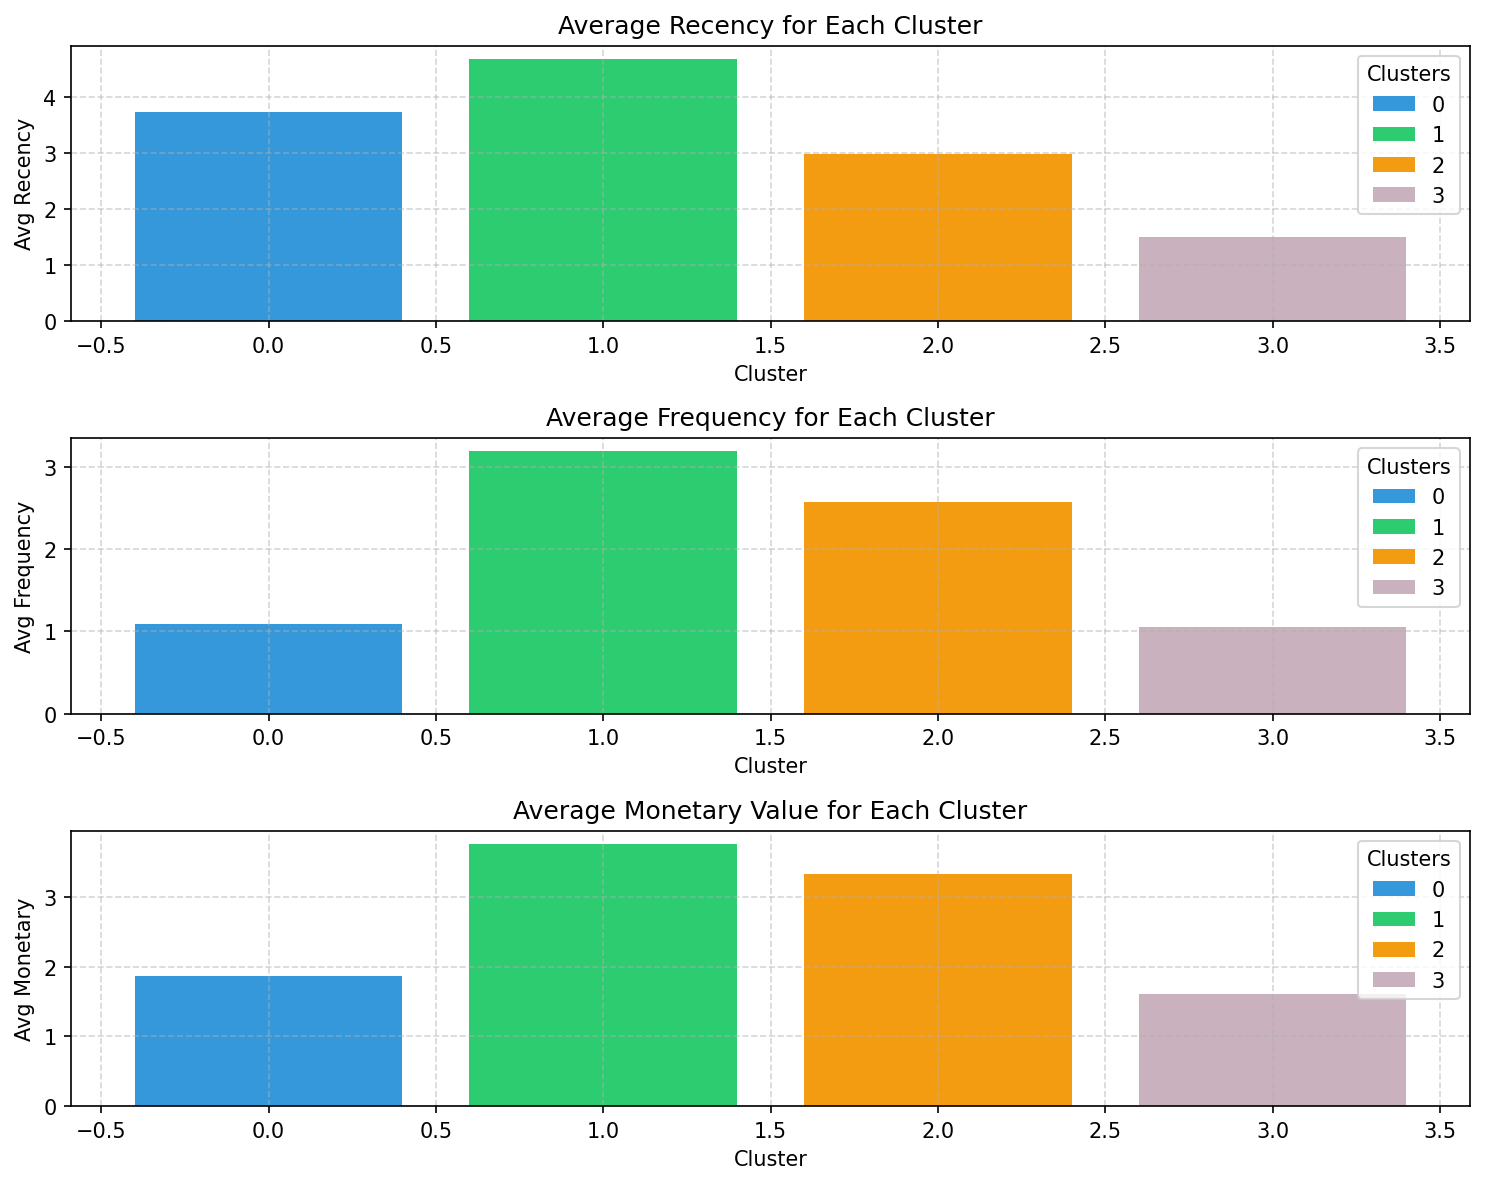

In [26]:
# In order to easily interpret the clusters, 
# we need to visualize the average R, F, and M scores for the clusters
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

Observe how each segment's clients can be classified according to their frequency, monetary values, and recentness:

* Cluster 0: This cluster has the highest frequency, monetary values, and recency of the four clusters. The clients in this cluster should be referred to as champions or power shoppers.
* Cluster 1: Moderate frequency, monetary amounts, and recency define this cluster. Compared to clusters 2 and 3, these clients continue to spend more and make more purchases. We'll refer to them as devoted clients.
* Cluster 2: Consumers in this group often spend less money. They don't buy frequently, and they haven't bought anything in a while. These clients are probably dormant or vulnerable.
* Cluster 3: This cluster is distinguished by moderate monetary values, comparatively low frequency, and high recency. Thus, these are new clients with the potential to become loyal ones.


To improve customer engagement and retention, you can target customers in each segment with customized marketing campaigns. Here are some examples:

* Outstanding Customers: To make Champions/Power Shoppers feel cherished and appreciated, provide them with early access, customized special offers, and other premium benefits.
* For Loyal Customers: Referral bonuses, loyalty awards, and appreciation initiatives.
* At-Risk Customers: Re-engagement initiatives for at-risk customers, such as offering sales or discounts to entice purchases.
* For Recent Customers: Tailored advertising efforts that inform them about the company and offer them savings on future purchases. 

Futher, knowing what proportion of customers fall into each category is also beneficial. This can help you expand your business and further streamline your marketing efforts.


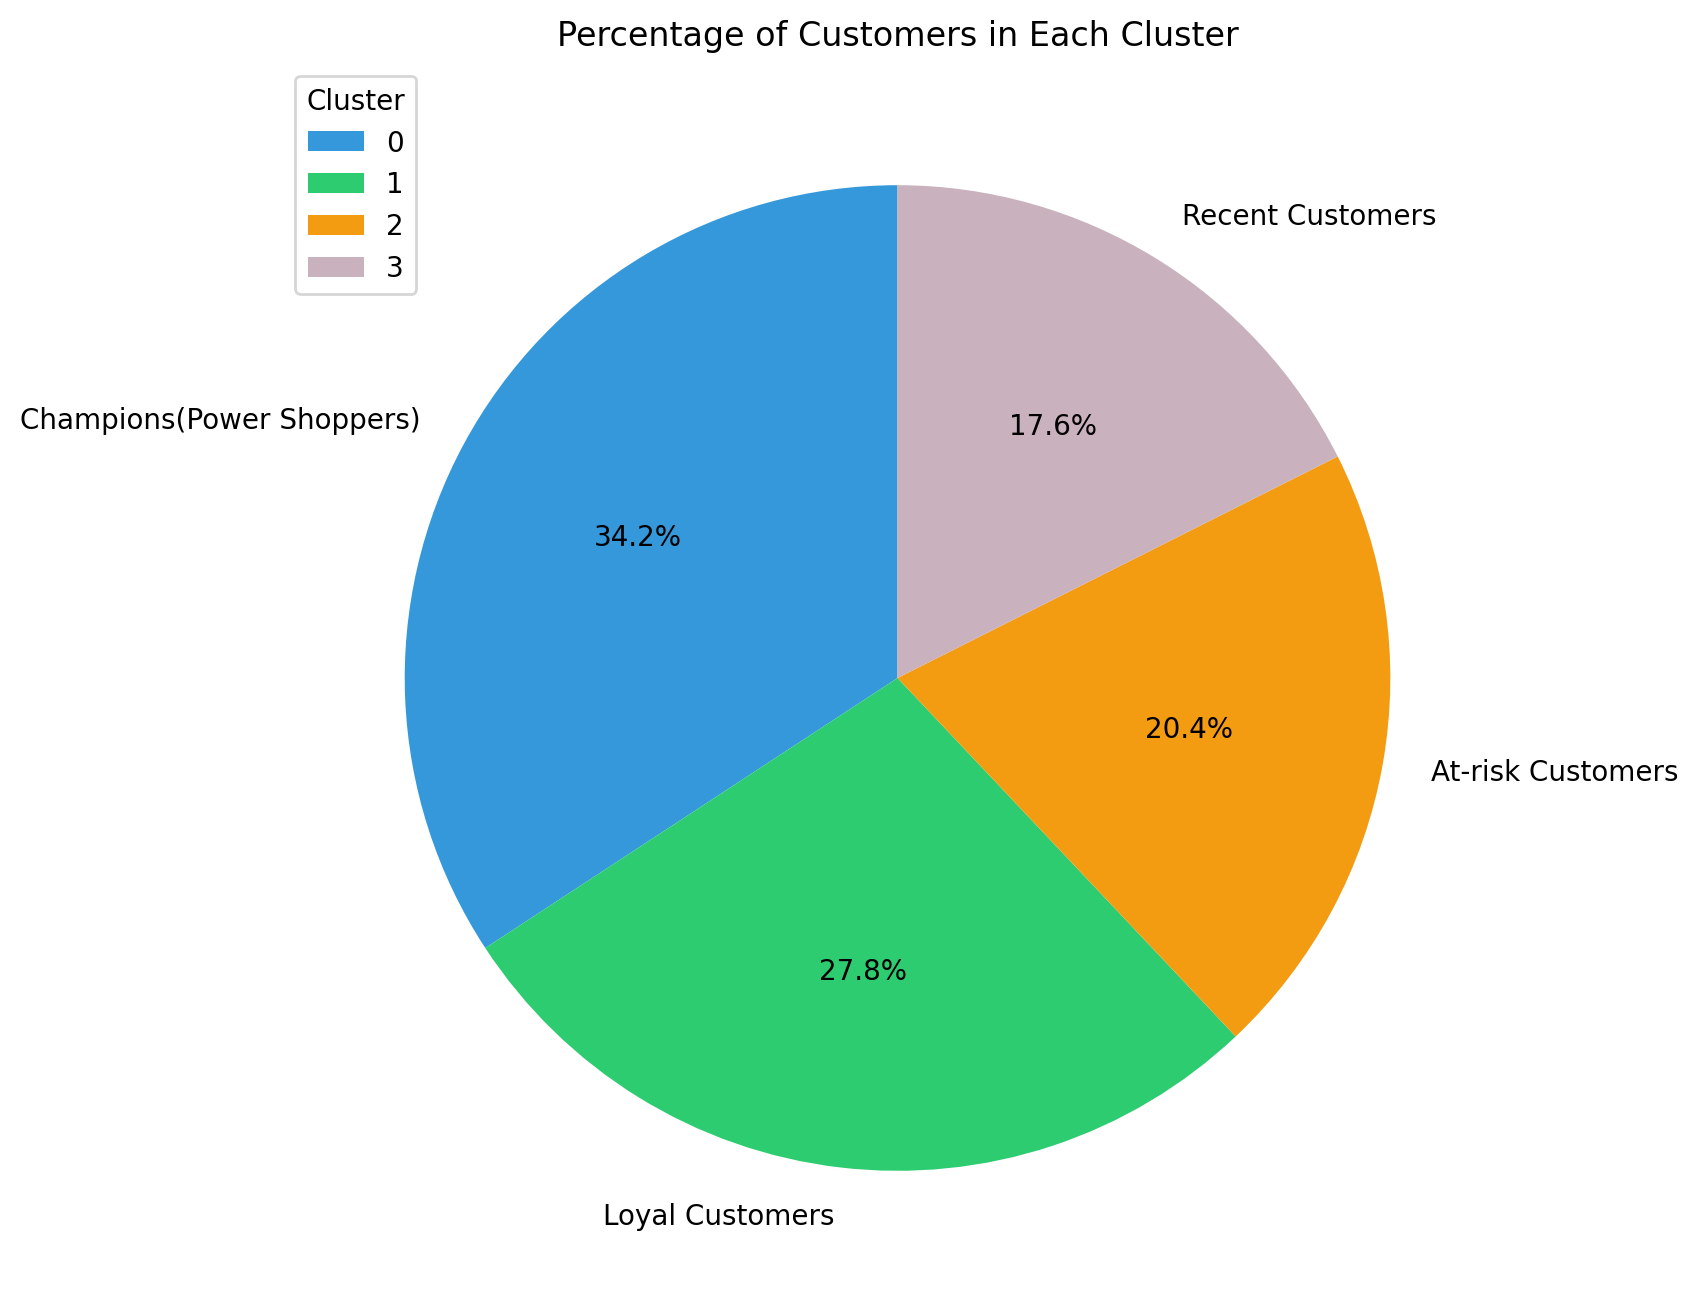

In [27]:
# visualize the distribution of the different clusters
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions(Power Shoppers)','Loyal Customers','At-risk Customers','Recent Customers']

# Create a pie chart
plt.figure(figsize=(8, 8),dpi=200)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()